In [64]:
from torchvision import transforms
import torch
import torchvision
import cv2
import numpy as np
from pathlib import Path
from emonet.models import EmoNet
from PIL import Image
from facenet_pytorch import MTCNN
import torchvision.transforms as T

t_p_transform = T.ToPILImage()
transform_image = transforms.Compose([transforms.ToTensor()])
mtcnn = MTCNN(keep_all=True)
classes = {0:"Neutral", 1:"Happy", 2:"Sad", 3:"Surprise", 4:"Fear", 5:"Disgust", 6:"Anger", 7:"Contempt"}
n_expression=8
image_size = 256
state_dict_path = Path().parent.joinpath('pretrained', f'emonet_{n_expression}.pth')
state_dict = torch.load(str(state_dict_path), map_location='cpu')
state_dict = {k.replace('module.',''):v for k,v in state_dict.items()}
net = EmoNet(n_expression=n_expression).to("cpu")
net.load_state_dict(state_dict, strict=False)
net.eval()

def recognize_emotion(pil_image, mtcnn, emonet):
    boxes, probs, points = mtcnn.detect(pil_image, landmarks=True)
    box = boxes[0]
    t_image = pil_image.crop(box.tolist())
    display(t_image)
    print(t_image.size)
    centercrop = torchvision.transforms.CenterCrop(np.min(t_image.size))
    resize = torchvision.transforms.Resize(256)
    t = transform_image(t_image)
    t = centercrop(t)
    t = resize(t)
    out = emonet(t[None, :])
    val = out['valence']
    ar = out['arousal']
    expr = out['expression']
    val = np.squeeze(val.detach().numpy()).item()
    ar = np.squeeze(ar.detach().numpy()).item()
    expr = np.argmax(np.squeeze(expr.detach().numpy()))
    return val, ar, classes[expr]

25.0


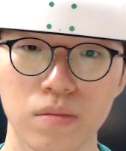

(126, 151)
valence:0.12500494718551636
arousal:0.0028156042098999023
emotion:Neutral


In [65]:
min = 17
sec = 41
ltime = min*60+sec
cap = cv2.VideoCapture('s2.mp4')
print(cap.get(cv2.CAP_PROP_FPS))
cap.set(cv2.CAP_PROP_POS_FRAMES, 25 * ltime)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)
#display(frame)
val, arousal, emotion = recognize_emotion(frame, mtcnn, net)
print(f"valence:{val}")
print(f"arousal:{arousal}")
print(f"emotion:{emotion}")